## ERA-5 End-to-End Data and Graphics Preparation for the Science-on-a-Sphere

This notebook will create all the necessary files and directories for a visualization on NOAA's Science-on-a-Sphere. For this example, we will produce a map of 500 hPa geopotential heights and sea-level pressure, using ERA-5 reanalysis, for the January 26 1978 intense surface cyclone, aka *The Cleveland Superbomb*.

## Overview:

1. Set up output directories for SoS
1. Programmatically request a specific date from the [RDA ERA-5 THREDDS repository](https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/catalog.html)
1. Re-arrange the order of the longitudinal dimension in the dataset
1. Use Cartopy's `add_cyclic_point` method to avoid a blank seam at the dateline
1. Create small and large thumbnail graphics.
1. Create a standalone colorbar
1. Create a set of labels for each plot
1. Create 24 hours worth of Science-on-a-Sphere-ready plots
1. Create an SoS playlist file


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Xarray  | Necessary | |
| Linux command line / directory structure | Helpful | |

* **Time to learn**: 30 minutes
***

## Imports

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd,MonthBegin
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util as cutil
import requests
from datetime import datetime, timedelta
import warnings
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt

Do not output warning messages

In [2]:
warnings.simplefilter("ignore")

## Set up output directories for SoS

The software that serves output for the Science-on-a-Sphere expects a directory structure as follows:
- Top level directory: choose a name that is consistent with your case, e.g.: **cle_superbomb**
- 2nd level directory: choose a name that is consistent with the graphic, e.g.: **SLP_500Z**
- 3rd level directories: 
    - **2048**: Contains the graphics (resolution: 2048x1024) that this notebook generates
    - **labels**: Contains one or two files:
        1. (required) A text file, `labels.txt`, which has as many lines as there are graphics in the **2048** file. Each line functions as the title of each graphic. 
        1. (optional) A PNG file, `colorbar.png`, which colorbar which will get overlaid on your map graphic.
    - **media**: Contains large and small thumbnails (`thumbnail_small.jpg`, `thumbnail_large.jpg`) that serve as icons on the SoS iPad and SoS computer apps
    - **playlist**: A text file, `playlist.sos`, which tells the SoS how to display your product
    
As an example, here is how the directory structure on our SoS looks for the products generated by this notebook. Our SoS computer stores locally-produced content in the `/shared/sos/media/site-custom` directory (note: the SoS directories are not network-accessible, so you won't be able to `cd` into them). The ERA-5 visualizations go in the `ERA5` subfolder. Your top-level directory sits within the `ERA5` folder.

```
sos@sos1:/shared/sos/media/site-custom/ERA5/cle_superbomb/SLP_500Z$ ls -R
.:
2048  labels  media  playlist

./2048:
ERA5_1978012600-fs8.png  ERA5_1978012606-fs8.png  ERA5_1978012612-fs8.png  ERA5_1978012618-fs8.png
ERA5_1978012601-fs8.png  ERA5_1978012607-fs8.png  ERA5_1978012613-fs8.png  ERA5_1978012619-fs8.png
ERA5_1978012602-fs8.png  ERA5_1978012608-fs8.png  ERA5_1978012614-fs8.png  ERA5_1978012620-fs8.png
ERA5_1978012603-fs8.png  ERA5_1978012609-fs8.png  ERA5_1978012615-fs8.png  ERA5_1978012621-fs8.png
ERA5_1978012604-fs8.png  ERA5_1978012610-fs8.png  ERA5_1978012616-fs8.png  ERA5_1978012622-fs8.png
ERA5_1978012605-fs8.png  ERA5_1978012611-fs8.png  ERA5_1978012617-fs8.png  ERA5_1978012623-fs8.png

./labels:
colorbar.png  labels.txt

./media:
thumbnail_big.jpg  thumbnail_small.jpg

./playlist:
playlist.sos
```

Define the 1st and 2nd-level directories.

In [3]:
# You define these
caseDir = 'cle_superbomb'
prodDir = 'SLP_500Z'

The 3rd-level directories follow from the 1st and 2nd.

In [4]:
# These remain as is
graphicsDir = caseDir + '/' + prodDir + '/2048/'
labelsDir = caseDir + '/' + prodDir + '/labels/'
mediaDir = caseDir + '/' + prodDir + '/media/'
playlistDir = caseDir + '/' + prodDir + '/playlist/'

Create these directories via a Linux command

In [5]:
! mkdir -p {graphicsDir} {labelsDir} {mediaDir} {playlistDir}

<div class="alert alert-info"><b>Note: </b>In a Jupyter notebook, the <code>!</code> magic indicates that what follows is a Linux command.<br>
The <code>-p</code> option for <code>mkdir</code> will create all subdirectories, and also will do nothing if the directories already exist.</div>

## Programmatically request a specific date from the [RDA ERA-5 THREDDS repository](https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/catalog.html)

The next several cells set the date/time, creates the URL strings, and retrieves selected grids from RDA.

In [6]:
# Select your date and time here
year = 1978
month = 1
day = 26
hour = 0

<div class="alert alert-danger">
    <b>One-day limit:</b> <br>
    While <b>Xarray</b> can create datasets and data arrays from multiple files, via its <code>open_mfdataset</code> method, this method does not reliably work when reading from a THREDDS server such as RDA's. Therefore, please restrict your temporal range to no more than one calendar day in this notebook.
        </div>

In [7]:
validTime = datetime(year, month, day, hour)
YYYYMM = validTime.strftime("%Y%m")
YYYYMMDD = validTime.strftime("%Y%m%d")

Among the many tools for time series analysis that Pandas provides are functions to determine the first and last days of a month.

In [8]:
monthEnd = pd.to_datetime(YYYYMM, format='%Y%m') + MonthEnd(0)
mEndStr = monthEnd.strftime('%Y%m%d23')

monthBeg = pd.to_datetime(YYYYMM, format='%Y%m') + MonthBegin(0)
mBegStr = monthBeg.strftime('%Y%m%d00')

dayBegStr = YYYYMMDD + '00'
dayEndStr = YYYYMMDD + '23'

dayBeg = datetime.strptime(dayBegStr, '%Y%m%d%H')
dayEnd = datetime.strptime(dayEndStr, '%Y%m%d%H')

In [9]:
dayBeg, dayEnd

(datetime.datetime(1978, 1, 26, 0, 0), datetime.datetime(1978, 1, 26, 23, 0))

In [10]:
monthBeg, monthEnd

(Timestamp('1978-01-01 00:00:00'), Timestamp('1978-01-31 00:00:00'))

Create the URLs for the various grids.

In [11]:
SfcURL = []
SfcURL.append('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.')
SfcURL.append(YYYYMM + '/e5.oper.an')
SfcURL.append('.ll025')
SfcURL.append('.' + mBegStr + '_' + mEndStr + '.nc')
print(SfcURL)

PrsURL = []
PrsURL.append('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.')
PrsURL.append(YYYYMM + '/e5.oper.an')
PrsURL.append('.ll025')
PrsURL.append('.' +  dayBegStr + '_' + dayEndStr + '.nc' )
print(PrsURL)

ds_urlZ = PrsURL[0] + 'pl/' + PrsURL[1] + '.pl.128_129_z' + PrsURL[2] + 'sc' + PrsURL[3]
ds_urlQ = PrsURL[0] + 'pl/' + PrsURL[1] + '.pl.128_133_q' + PrsURL[2] + 'sc' + PrsURL[3]
ds_urlT = PrsURL[0] + 'pl/' + PrsURL[1] + '.pl.128_130_t' + PrsURL[2] + 'sc' + PrsURL[3]
# Notice that U and V use "uv" instead of "sc" in their name!
ds_urlU = PrsURL[0] + 'pl/' + PrsURL[1] + '.pl.128_131_u' + PrsURL[2] + 'uv' + PrsURL[3]
ds_urlV = PrsURL[0] + 'pl/' + PrsURL[1] + '.pl.128_132_v' + PrsURL[2] + 'uv' + PrsURL[3]

ds_urlU10 = SfcURL[0] + 'sfc/' + SfcURL[1] + '.sfc.128_165_10u' + SfcURL[2] + 'sc' + SfcURL[3]
ds_urlV10 = SfcURL[0] + 'sfc/' + SfcURL[1] + '.sfc.128_166_10v' + SfcURL[2] + 'sc' + SfcURL[3]
ds_urlSLP = SfcURL[0] + 'sfc/' + SfcURL[1] + '.sfc.128_151_msl' + SfcURL[2] + 'sc' + SfcURL[3]

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.', '197801/e5.oper.an', '.ll025', '.1978010100_1978013123.nc']
['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.', '197801/e5.oper.an', '.ll025', '.1978012600_1978012623.nc']


<div class="alert alert-info"> <b>NOTE:</b> You can find tables listing all of the various parameters in the ERA-5 datasets at <a href='https://rda.ucar.edu/datasets/ds633.0/?hash=access#!docs'> this link</a> </div>

Use your RDA credentials to access these individual NetCDF files. You should have previously registered with RDA, and then saved your user id and password in your home directory as .rdarc , with permissions such that only you have read/write access.

In [12]:
#Retrieve login credential for RDA.
from pathlib import Path
HOME = str(Path.home())
credFile = open(HOME+'/.rdarc','r')
userId, pw = credFile.read().split()

Connect to the RDA THREDDS server and point to the files of interest. Here, we'll comment out the ones we are not interested in but can always uncomment when we want them. 

In [13]:
session = requests.Session()
session.auth = (userId, pw)
#storeU10 = xr.backends.PydapDataStore.open(ds_urlU10, session=session)
#storeV10 = xr.backends.PydapDataStore.open(ds_urlV10, session=session)
storeSLP = xr.backends.PydapDataStore.open(ds_urlSLP, session=session)
#storeQ = xr.backends.PydapDataStore.open(ds_urlQ, session=session)
#storeT = xr.backends.PydapDataStore.open(ds_urlT, session=session)
#storeU = xr.backends.PydapDataStore.open(ds_urlU, session=session)
#storeV = xr.backends.PydapDataStore.open(ds_urlV, session=session)
storeZ = xr.backends.PydapDataStore.open(ds_urlZ, session=session)

In [14]:
ds_urlSLP

'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/197801/e5.oper.an.sfc.128_151_msl.ll025sc.1978010100_1978013123.nc'

In [15]:
#dsU10 = xr.open_dataset(storeU10)
#dsV10 = xr.open_dataset(storeV10)
dsSLP = xr.open_dataset(storeSLP)
#dsQ   = xr.open_dataset(storeQ)
#dsT   = xr.open_dataset(storeT)
#dsU   = xr.open_dataset(storeU)
#dsV   = xr.open_dataset(storeV)
dsZ   = xr.open_dataset(storeZ)

### Examine the datasets

The surface fields span the entire month. Let's restrict the range so it matches the day of interest.

In [16]:
dsSLP = dsSLP.sel(time=slice(dayBeg,dayEnd))

Create an Xarray DataArray object for SLP and perform unit conversion

In [17]:
SLP = dsSLP['MSL']
SLP = SLP.metpy.convert_units('hPa')

Examine the SLP DataArray

In [18]:
SLP

<xarray.DataArray 'MSL' (time: 24, latitude: 721, longitude: 1440)>
<Quantity([[[1032.5399  1032.5399  1032.5399  ... 1032.5399  1032.5399  1032.5399 ]
  [1032.82    1032.8225  1032.8225  ... 1032.8175  1032.8175  1032.82   ]
  [1033.0275  1033.03    1033.0325  ... 1033.0225  1033.025   1033.025  ]
  ...
  [1009.8475  1009.85    1009.85    ... 1009.83997 1009.84247 1009.845  ]
  [1009.77747 1009.77747 1009.77496 ... 1009.77496 1009.77496 1009.77747]
  [1009.69    1009.69    1009.69    ... 1009.69    1009.69    1009.69   ]]

 [[1031.6238  1031.6238  1031.6238  ... 1031.6238  1031.6238  1031.6238 ]
  [1031.9113  1031.9137  1031.9137  ... 1031.9087  1031.9113  1031.9113 ]
  [1032.1162  1032.1188  1032.1212  ... 1032.1112  1032.1138  1032.1162 ]
  ...
  [1009.84375 1009.84625 1009.84625 ... 1009.83875 1009.83875 1009.84125]
  [1009.78625 1009.78625 1009.78625 ... 1009.78625 1009.78625 1009.78625]
  [1009.70874 1009.70874 1009.70874 ... 1009.70874 1009.70874 1009.70874]]

 [[1031.6018  1031.6018  1031.6018  ... 1031.6018  1031.6018  1031.6018 ]
  [1031.8993  1031.8993  1031.8993  ... 1031.8944  1031.8969  1031.8969 ]
  [1032.1194  1032.1218  1032.1244  ... 1032.1144  1032.1144  1032.1168 ]
  ...
...
  ...
  [1006.08435 1006.08185 1006.07935 ... 1006.08936 1006.08435 1006.08435]
  [1006.33185 1006.32935 1006.32684 ... 1006.33685 1006.33685 1006.33435]
  [1006.89185 1006.89185 1006.89185 ... 1006.89185 1006.89185 1006.89185]]

 [[1021.5062  1021.5062  1021.5062  ... 1021.5062  1021.5062  1021.5062 ]
  [1021.96375 1021.96625 1021.96875 ... 1021.95624 1021.95874 1021.96124]
  [1022.4337  1022.4387  1022.4437  ... 1022.4212  1022.4237  1022.4287 ]
  ...
  [1009.1812  1009.1837  1009.1812  ... 1009.1787  1009.1787  1009.1787 ]
  [1008.89374 1008.89124 1008.89124 ... 1008.89374 1008.89374 1008.89374]
  [1008.97125 1008.97125 1008.97125 ... 1008.97125 1008.97125 1008.97125]]

 [[1021.305   1021.305   1021.305   ... 1021.305   1021.305   1021.305  ]
  [1021.72    1021.72    1021.7225  ... 1021.71246 1021.71497 1021.71747]
  [1022.13995 1022.14496 1022.14996 ... 1022.13    1022.1325  1022.13745]
  ...
  [1009.005   1009.0075  1009.00995 ... 1009.      1009.      1009.     ]
  [1008.6925  1008.6925  1008.6925  ... 1008.6925  1008.6925  1008.6925 ]
  [1008.8075  1008.8075  1008.8075  ... 1008.8075  1008.8075  1008.8075 ]]], 'hectopascal')>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1978-01-26 ... 1978-01-26T23:00:00
Attributes:
    long_name:                                          Mean sea level pressure
    short_name:                                         msl
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    151
    minimum_value:                                      93279.19
    maximum_value:                                      106472.31
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    _ChunkSizes:                                        [27, 139, 277]

Now examine the geopotential data on isobaric surfaces.

In [19]:
dsZ

<xarray.Dataset>
Dimensions:    (time: 24, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1978-01-26 ... 1978-01-26T23:00:00
Data variables:
    Z          (time, level, latitude, longitude) float32 ...
    utc_date   (time) int32 ...
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.8.1
    CONVERSION_PLATFORM:             Linux r1i3n32 4.12.14-95.51-default #1 S...
    CONVERSION_DATE:                 Sun Jul  3 14:02:30 MDT 2022
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Sun Jul  3 14:03:04 2022: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

To reduce the memory footprint for data on isobaric surfaces, let's request only 6 out of the 37 available levels.

In [20]:
dsZ = dsZ.sel(level = [200,300,500,700,850,1000])

In [21]:
dsZ

<xarray.Dataset>
Dimensions:    (time: 24, level: 6, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) float64 200.0 300.0 500.0 700.0 850.0 1e+03
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1978-01-26 ... 1978-01-26T23:00:00
Data variables:
    Z          (time, level, latitude, longitude) float32 ...
    utc_date   (time) int32 1978012600 1978012601 ... 1978012622 1978012623
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.8.1
    CONVERSION_PLATFORM:             Linux r1i3n32 4.12.14-95.51-default #1 S...
    CONVERSION_DATE:                 Sun Jul  3 14:02:30 MDT 2022
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Sun Jul  3 14:03:04 2022: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

Create an Xarray DataArray object for Z

In [22]:
Z = dsZ['Z']

In [23]:
Z

<xarray.DataArray 'Z' (time: 24, level: 6, latitude: 721, longitude: 1440)>
[149506560 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) float64 200.0 300.0 500.0 700.0 850.0 1e+03
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1978-01-26 ... 1978-01-26T23:00:00
Attributes:
    long_name:                                          Geopotential
    short_name:                                         z
    units:                                              m**2 s**-2
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    129
    minimum_value:                                      -4556.6367
    maximum_value:                                      494008.56
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric pres...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    _ChunkSizes:                                        [1, 37, 721, 1440]

Set contour levels for both SLP and Z. 

In [24]:
slpLevels = np.arange(864,1080,4)

Choose a particular isobaric surface.

In [25]:
pLevel = 500

Redefine Z so it consists only of the data at the level you just chose.

In [26]:
Z = Z.sel(level=pLevel)

Science-on-a-Sphere's background maps require that projected images, besides using Plate Carree projection, extend from -180 to +180 degrees longitude. The ERA-5 datasets' longitudinal coordinates start at 0 and go to 360. Although we won't be using those maps (instead, we will add map borders to our graphic using Cartopy), let's define a function that re-sorts datasets (or data arrays) so the longitudinal range begins at the dateline instead of the Greenwich meridian.

In [27]:
def reSortCoords(d):
    longitudeName = 'longitude'
    d.coords[longitudeName] = (d.coords[longitudeName] + 180) % 360 - 180
    d = d.sortby(d[longitudeName])
    return d

In [28]:
Z = reSortCoords(Z)
SLP = reSortCoords(SLP)

Examine one of the re-sorted data arrays

In [29]:
SLP

<xarray.DataArray 'MSL' (time: 24, latitude: 721, longitude: 1440)>
<Quantity([[[1032.5399  1032.5399  1032.5399  ... 1032.5399  1032.5399  1032.5399 ]
  [1032.28    1032.2775  1032.2775  ... 1032.2825  1032.2825  1032.28   ]
  [1031.955   1031.9525  1031.95    ... 1031.9625  1031.96    1031.9575 ]
  ...
  [1008.3675  1008.375   1008.38495 ... 1008.33997 1008.35    1008.3575 ]
  [1009.4975  1009.5025  1009.505   ... 1009.485   1009.4875  1009.4925 ]
  [1009.69    1009.69    1009.69    ... 1009.69    1009.69    1009.69   ]]

 [[1031.6238  1031.6238  1031.6238  ... 1031.6238  1031.6238  1031.6238 ]
  [1031.3638  1031.3612  1031.3612  ... 1031.3662  1031.3662  1031.3638 ]
  [1031.0387  1031.0363  1031.0337  ... 1031.0437  1031.0413  1031.0387 ]
  ...
  [1008.32874 1008.33875 1008.34625 ... 1008.3012  1008.3087  1008.3187 ]
  [1009.4912  1009.4962  1009.5012  ... 1009.47626 1009.4812  1009.4862 ]
  [1009.70874 1009.70874 1009.70874 ... 1009.70874 1009.70874 1009.70874]]

 [[1031.6018  1031.6018  1031.6018  ... 1031.6018  1031.6018  1031.6018 ]
  [1031.3368  1031.3344  1031.3344  ... 1031.3394  1031.3394  1031.3368 ]
  [1031.0194  1031.0168  1031.0144  ... 1031.0269  1031.0243  1031.0219 ]
  ...
...
  ...
  [1005.88434 1005.89685 1005.91187 ... 1005.84186 1005.8569  1005.8693 ]
  [1006.70935 1006.71686 1006.72186 ... 1006.68933 1006.69434 1006.70184]
  [1006.89185 1006.89185 1006.89185 ... 1006.89185 1006.89185 1006.89185]]

 [[1021.5062  1021.5062  1021.5062  ... 1021.5062  1021.5062  1021.5062 ]
  [1021.08374 1021.08124 1021.07874 ... 1021.08875 1021.08624 1021.08624]
  [1020.7362  1020.7337  1020.7287  ... 1020.7462  1020.7437  1020.7387 ]
  ...
  [1008.1287  1008.13873 1008.14874 ... 1008.09875 1008.1087  1008.1187 ]
  [1008.8537  1008.8587  1008.8637  ... 1008.83875 1008.84375 1008.84875]
  [1008.97125 1008.97125 1008.97125 ... 1008.97125 1008.97125 1008.97125]]

 [[1021.305   1021.305   1021.305   ... 1021.305   1021.305   1021.305  ]
  [1020.86    1020.86    1020.8575  ... 1020.8675  1020.865   1020.8625 ]
  [1020.3575  1020.3525  1020.3475  ... 1020.37    1020.365   1020.36   ]
  ...
  [1007.8825  1007.89246 1007.90247 ... 1007.855   1007.865   1007.875  ]
  [1008.67    1008.675   1008.68    ... 1008.65497 1008.66    1008.665  ]
  [1008.8075  1008.8075  1008.8075  ... 1008.8075  1008.8075  1008.8075 ]]], 'hectopascal')>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1978-01-26 ... 1978-01-26T23:00:00
Attributes:
    long_name:                                          Mean sea level pressure
    short_name:                                         msl
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    151
    minimum_value:                                      93279.19
    maximum_value:                                      106472.31
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    _ChunkSizes:                                        [27, 139, 277]

Notice that the longitude dimension now begins at -180.

For the purposes of plotting geopotential heights in decameters, choose an appropriate contour interval and range of values ... for geopotential heights, a common convention is: from surface up through 700 hPa: 3 dam; above that, 6 dam to 400 and then 9 or 12 dam from 400 and above.

In [30]:
if (pLevel == 1000):
    zLevels= np.arange(-90,63, 3)
elif (pLevel == 850):
    zLevels = np.arange(60, 183, 3)
elif (pLevel == 700):
    zLevels = np.arange(201, 339, 3)
elif (pLevel == 500):
    zLevels = np.arange(468, 606, 6)
elif (pLevel == 300):
    zLevels = np.arange(765, 1008, 9)
elif (pLevel == 200): 
    zLevels = np.arange(999, 1305, 9)

<div class="alert alert-info">In this notebook, we did not retrieve the U- and V- wind component grids. However, if you end up modifying this notebook to do so, uncomment the lines in the following cell.</div>

In [31]:
#print (U.units)
## Convert wind from m/s to knots; use MetPy to calculate the wind speed.
#UKts = U.metpy.convert_units('knots')
#VKts = V.metpy.convert_units('knots')
## Calculate windspeed.
#wspdKts = calc.wind_speed(U,V).to('knots')

Create objects for the relevant coordinate arrays; in this case, *longitude*, *latitude*, and *time*.

In [32]:
lons, lats, times= SLP.longitude, SLP.latitude, SLP.time

Take a peek at a couple of these coordinate arrays.

In [33]:
lons

<xarray.DataArray 'longitude' (longitude: 1440)>
array([-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75])
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

<div class="alert alert-warning">Notice that the longitudinal array extends to 179.75, not 180. We will use Cartopy's <code>add_cyclic_point</code> method to eliminate the resulting seam.</div>

In [34]:
times

<xarray.DataArray 'time' (time: 24)>
array(['1978-01-26T00:00:00.000000000', '1978-01-26T01:00:00.000000000',
       '1978-01-26T02:00:00.000000000', '1978-01-26T03:00:00.000000000',
       '1978-01-26T04:00:00.000000000', '1978-01-26T05:00:00.000000000',
       '1978-01-26T06:00:00.000000000', '1978-01-26T07:00:00.000000000',
       '1978-01-26T08:00:00.000000000', '1978-01-26T09:00:00.000000000',
       '1978-01-26T10:00:00.000000000', '1978-01-26T11:00:00.000000000',
       '1978-01-26T12:00:00.000000000', '1978-01-26T13:00:00.000000000',
       '1978-01-26T14:00:00.000000000', '1978-01-26T15:00:00.000000000',
       '1978-01-26T16:00:00.000000000', '1978-01-26T17:00:00.000000000',
       '1978-01-26T18:00:00.000000000', '1978-01-26T19:00:00.000000000',
       '1978-01-26T20:00:00.000000000', '1978-01-26T21:00:00.000000000',
       '1978-01-26T22:00:00.000000000', '1978-01-26T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1978-01-26 ... 1978-01-26T23:00:00
Attributes:
    long_name:    time
    _ChunkSizes:  1024

## Create contour plots of SLP and geopotential height.
Let's create a plot for a single time, just to ensure all looks good.

In [35]:
proj_data = ccrs.PlateCarree() # The dataset's x- and y- coordinates are lon-lat

<div class="alert alert-info"><b>Note: </b>The Science on a Sphere treats titles and colorbars as separate layers. Thus, in this next cell we will not generate nor include them in the figure.<br>
Additionally, the sphere expects its graphics to have a resolution of 2048x1024.<br>
Finally, by default, Matplotlib includes a border frame around each <code>Axes</code>. We don't want that included on the sphere-projected graphic either.</div>

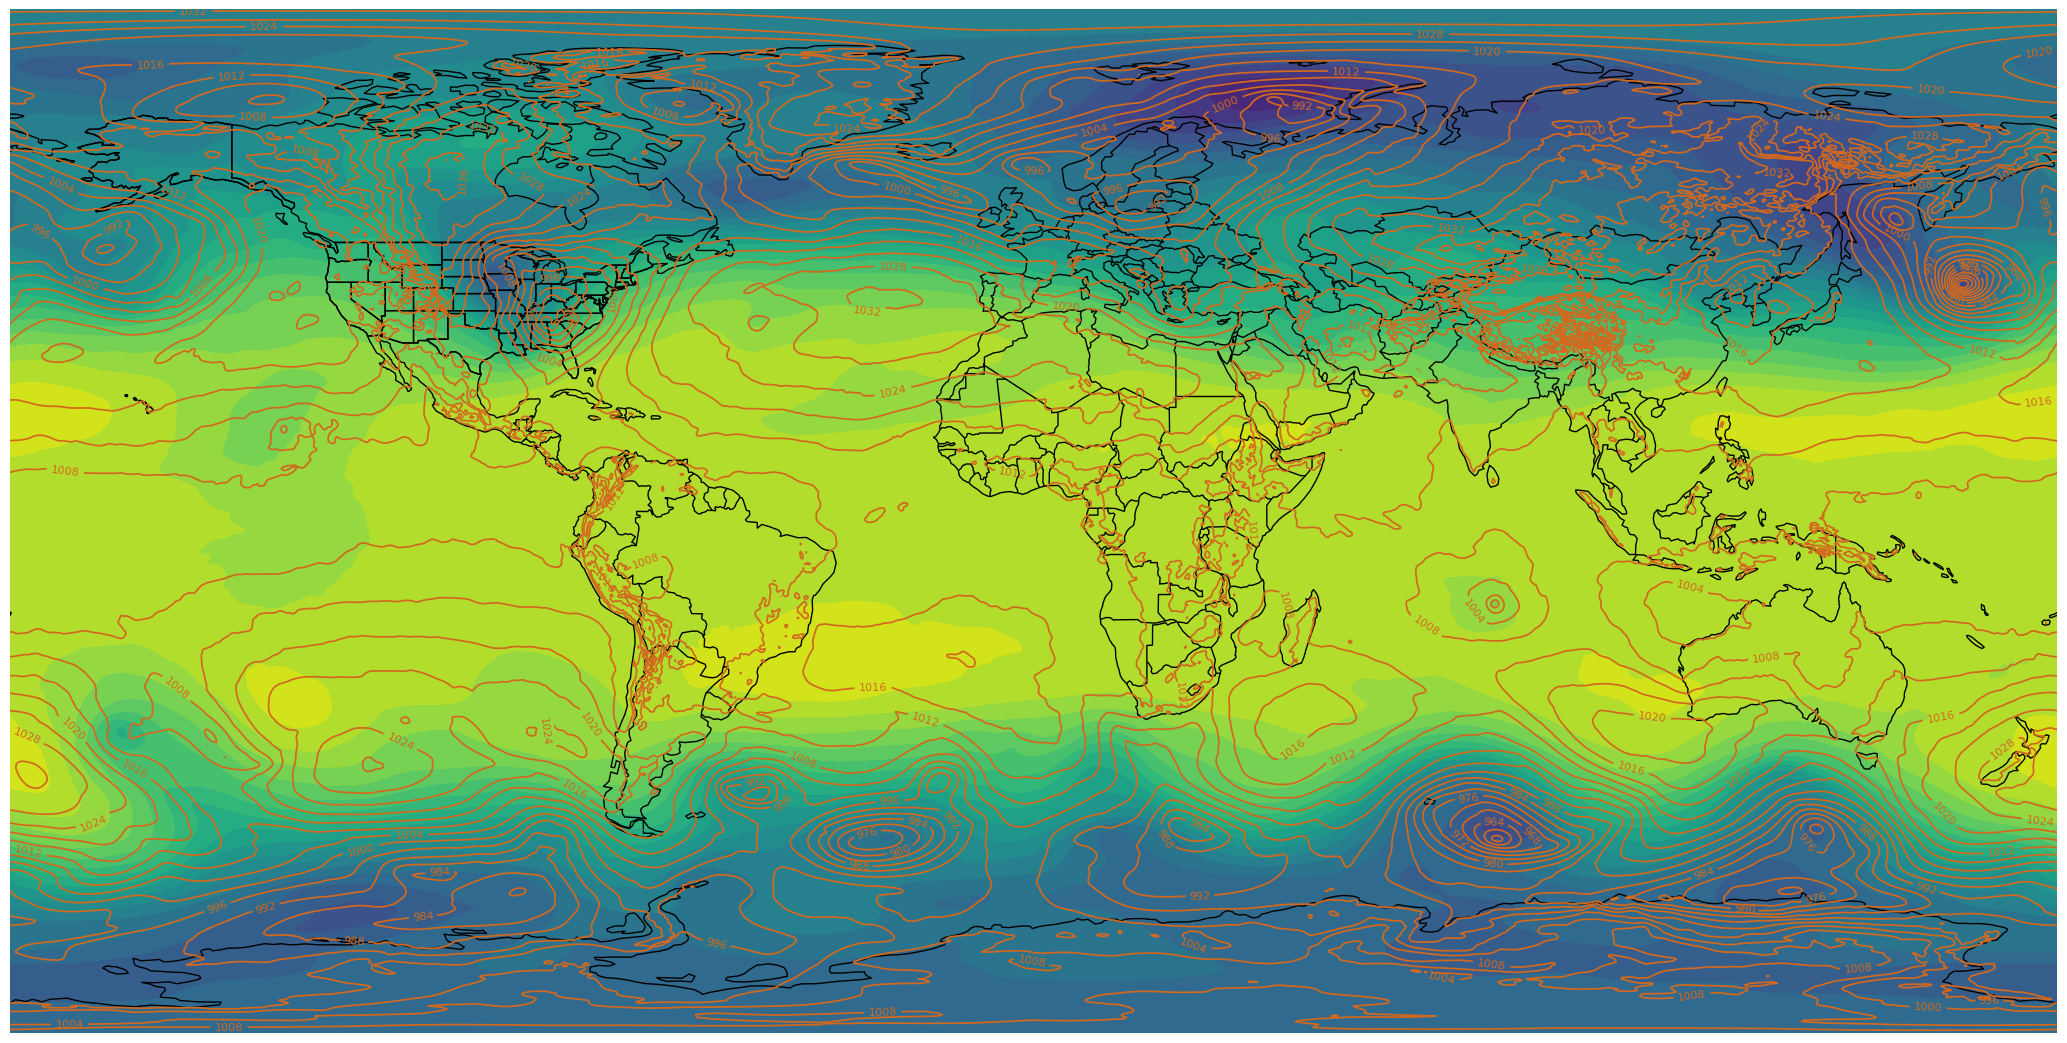

In [36]:
res = '110m'
dpi = 100
fig = plt.figure(figsize=(2048/dpi, 1024/dpi))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(), frameon=False)
ax.set_global()
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.BORDERS.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Convert from units of geopotential to height in decameters.
Zdam = mpcalc.geopotential_to_height(Z.isel(time=0)).metpy.convert_units('dam')

# add cyclic points to data and longitudes
# latitudes are unchanged in 1-dimension
SLP2d, clons= cutil.add_cyclic_point(SLP.isel(time=0), lons)
z2d, clons = cutil.add_cyclic_point(Zdam, lons)

# Height (Z) contour fills

# Note we don't need the transform argument since the map/data projections are the same, but we'll leave it in
CF = ax.contourf(clons,lats,z2d,levels=zLevels,cmap=plt.get_cmap('viridis'), extend='both', transform=proj_data) 

# SLP contour lines
CL = ax.contour(clons,lats,SLP2d,slpLevels,linewidths=1.25,colors='chocolate', transform=proj_data)
ax.clabel(CL, inline_spacing=0.2, fontsize=8, fmt='%.0f')
fig.tight_layout(pad=.01)

# Save this figure to your current directory
fig.savefig('test_ERA_SOS.png')

## If you'd like, go to https://maptoglobe.com and view how your graphic might look on the sphere.

<div class="alert alert-warning"><b>Note:</b> If you get an error message from the <i>maptoglobe.com</i> site, try reloading. Usually it will load correctly on the 2nd try.</div>

Follow these steps:

<div class="alert alert-info">You can find screenshots of some of these steps at the [Jupyterbook version of this notebook]()</div>

1. Download the `test_ERA5_SOS.png` file to your local computer
1. Click on the **Images** tab on the *maptoglobe* site
1. Next to **Surface**, click on *Choose a file*
1. Navigate to the folder in which you downloaded the PNG, select the PNG, and click on **OK**
1. You should then see your map! Use your mouse to move the globe around; also use the mouse wheel to zoom in and out.
1. If the image looks good, you're ready to move forward!

You should see the following after successfully connecting to the *maptoglobe* site:
<center><img src="../images/maptoglobe1.png" alt="M2G" style="width: 350px;"/></center>


Then, follow these steps:
1. Download the `test_ERA5_SOS.png` file to your local computer
1. Click on the **Images** tab on the *maptoglobe* site
1. Next to **Surface**, click on *Choose a file*
<center><img src="../images/MtGChooseSurface.png" alt="M2GSfcChoose" style="width: 350px;"/></center>
1. Navigate to the folder in which you downloaded the PNG, select the PNG, and click on **OK**
<center><img src="../images/MtGSelectPNG.png" alt="M2GSelectPNG" style="width: 350px;"/></center>
1. You should then see your map! Use your mouse to move the globe around; also use the mouse wheel to zoom in and out.
<center><img src="../images/MtGView.png" alt="M2GView" style="width: 350px;"/></center>
1. If the image looks good, you're ready to move forward!

## Create small (128x128) and large (800x800) thumbnails. These will serve as icons in the SoS iPad and computer apps that go along with your particular product.
We'll use the orthographic projection and omit the contour lines and some of the cartographic features, and add a title string.

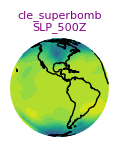

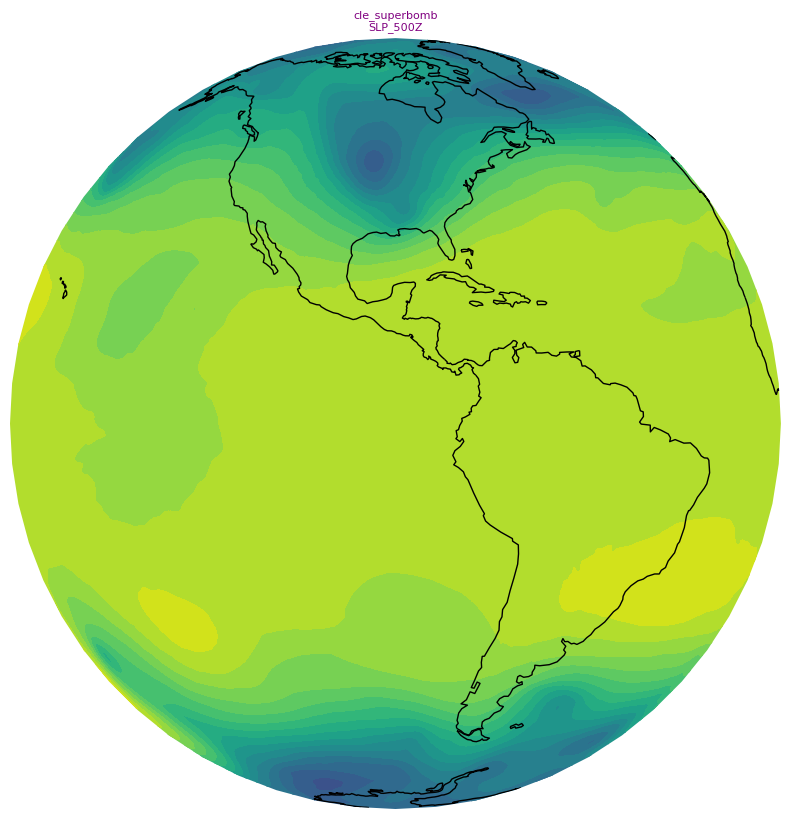

In [37]:
res = '110m'
dpi = 100
for size in (128, 800):
    if (size == 128):
        sizeStr = 'small'
    else:
        sizeStr ='big'
        
    fig = plt.figure(figsize=(size/dpi, size/dpi))
    ax = plt.subplot(1,1,1,projection=ccrs.Orthographic(central_longitude=-90), frameon=False)
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    tl1 = caseDir
    tl2 = prodDir
    ax.set_title(tl1 + '\n' + tl2, color='purple', fontsize=8)

    # Height (Z) contour fills

    CF = ax.contourf(clons,lats,z2d,levels=zLevels,cmap=plt.get_cmap('viridis'), extend='both', transform=proj_data) 

    fig.tight_layout(pad=.01)
    fig.savefig(mediaDir + 'thumbnail_' + sizeStr + '.jpg')

## Create a standalone colorbar
Visualizations on the Science-on-a-Sphere consist of a series of image files, layered on top of each other. In this example, instead of having the colorbar associated with 500 hPa heights adjacent to the map, let's use a technique by which we remove the contour plot, leaving only the colorbar to be exported as an image. We change the colorbar's orientation to horizontal, and also change its tick label colors so they will be more visible on the sphere's display.

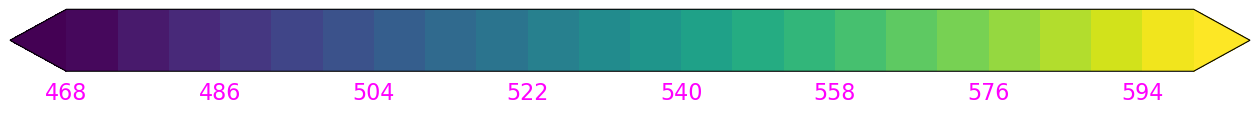

In [38]:
# draw a new figure and replot the colorbar there
fig,ax = plt.subplots(figsize=(16,2), dpi=100)
# set tick and ticklabel color
tick_color='white'
label_color='magenta'
cbar = fig.colorbar(CF, ax=ax, orientation='horizontal', fraction=0.5)
cbar.ax.xaxis.set_tick_params(color=tick_color, labelcolor=label_color,labelsize=16)
# Remove the Axes object ... essentially the contours and cartographic features ... from the figure.
ax.remove()
# All that remains is the colorbar ... save it to disk. Make the background transparent.
fig.savefig(labelsDir + 'colorbar.png',transparent=True)

## Create a set of labels for each plot

In [39]:
labelFname = labelsDir + 'labels.txt'

## Define a function to create the plot for each hour. 
The function accepts the hour and a <code>DataArray</code> as its arguments.

In [40]:
def make_sos_map (i, z):
    res = '110m'
    dpi = 100
    fig = plt.figure(figsize=(2048/dpi, 1024/dpi))
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(), frameon=False)
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.BORDERS.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res))

    # add cyclic points to data and longitudes
    # latitudes are unchanged in 1-dimension
    SLP2d, clons= cutil.add_cyclic_point(SLP.isel(time=i), lons)
    z2d, clons = cutil.add_cyclic_point(z, lons)

    # Height (Z) contour fills

    CF = ax.contourf(clons,lats,z2d,levels=zLevels,cmap=plt.get_cmap('viridis'), extend='both') 

    # SLP contour lines
    CL = ax.contour(clons,lats,SLP2d,slpLevels,linewidths=1.25,colors='chocolate', transform=proj_data)
    ax.clabel(CL, inline_spacing=0.2, fontsize=8, fmt='%.0f')
    fig.tight_layout(pad=.01)
    frameNum = str(i).zfill(2)
    figName = graphicsDir + "ERA5_"+ YYYYMMDD + frameNum + '.png'
    fig.savefig(figName)
    
    # Reduce the size of the PNG image via the Linux pngquant utility. The -f option overwites the resulting file if it already exists.
    # The output file will end in "-fs8.png"
    ! pngquant -f {figName}
    
    # Remove the original PNG
    ! rm -f {figName}
    
    # Do not show the graphic in the notebook
    plt.close()

<div class="alert alert-warning">When making your own products, modify/eliminate the line that performs unit conversions depending on what scalar/vector you wish to plot. </div>

## Create the graphics and titles
- Open a handle to the labels file
- Define the time dimension index's start, end, and increment values
- Loop over the 24 hours
  - Perform any necessary unit conversions
  - Create each hour's graphic
  - Write the title line to the text file.
- Close the handle to the labels file

<div class="alert alert-warning">For demonstration purposes, we will use a time increment of <b>12</b> hours ... thus only <b>2</b> graphics will be produced. When you are ready, change the <code>inc</code> to <b>1</b> so all hours are processed. </div>

In [41]:
labelFileObject = open(labelFname, 'w')
startHr = 0
endHr = 24
inc = 12 # Change to 1 when ready

for time in range(startHr, endHr, inc):
    
    # Perform any unit conversions appropriate for your scalar quantities. In this example,
    # we convert geopotential to geopotential height in decameters.

    z = mpcalc.geopotential_to_height(Z.isel(time=time)).metpy.convert_units('dam')
    make_sos_map(time,z)
    
    # Construct the title string and write it to the file
    valTime = pd.to_datetime(times[time].values).strftime("%m/%d/%Y %H UTC")
    tl1 = str("ERA-5 SLP & " + str(pLevel) + " hPa Z " + valTime + "\n") # \n is the newline character
    labelFileObject.write(tl1)
    print(tl1)
# Close the text file
labelFileObject.close()

ERA-5 SLP & 500 hPa Z 01/26/1978 00 UTC

ERA-5 SLP & 500 hPa Z 01/26/1978 12 UTC



## Close the file handles to the remote RDA THREDDS server.
Modify as needed ... close whatever `Dataset` objects you created via Xarray's `open_dataset` method earlier in the notebook.

In [42]:
dsSLP.close()
dsZ.close()

## Create an SoS playlist file
We follow the guidelines in https://sos.noaa.gov/support/sos/manuals/datasets/playlists/#dataset-playlist.sos-files

In [43]:
playlistFname = playlistDir + 'playlist.sos'

- Open a file handle to the playlist file
- Add each line of the playlist. *Modify as needed for your case and product; in general you will only need to modify the **name**, **description**, and **creatorname** values!*
- Close the file handle 

In [44]:
plFileObject = open(playlistFname, 'w')
subCat = "ERA5"
cRet = "\n" # New line character code

##Modify these next three lines to fit your case
nameStr = "Cleveland Superbomb 1978 SLP/500 Z"
descriptionStr = '{{ ERA-5 January 26 1978 ("Cleveland Superbomb") }}'
creaName = "Firstname Lastname" # Put your name here!

plFileObject.write("name = " + nameStr + cRet )
plFileObject.write("description = " + descriptionStr + cRet)

plFileObject.write("pip = ../labels/colorbar.png" + cRet)
plFileObject.write("pipheight = 10" + cRet)
plFileObject.write("pipvertical = -35" + cRet)

plFileObject.write("label = ../labels/labels.txt" + cRet)
plFileObject.write("layer = Grids" + cRet)
plFileObject.write("layerdata = ../2048" + cRet)

plFileObject.write("firstdwell = 2000" + cRet)
plFileObject.write("lastdwell = 3000" + cRet)
plFileObject.write("fps = 8" + cRet)

plFileObject.write("zrotationenable = 1" + cRet)
plFileObject.write("zfps = 30" + cRet)

plFileObject.write("subcategory = " + subCat + cRet)
plFileObject.write("Creator = " + creaName + cRet)
                   
plFileObject.close()

Display the contents of the playlist file

In [45]:
! cat {playlistFname}

name = Cleveland Superbomb 1978 SLP/500 Z
description = {{ ERA-5 January 26 1978 ("Cleveland Superbomb") }}
pip = ../labels/colorbar.png
pipheight = 10
pipvertical = -35
label = ../labels/labels.txt
layer = Grids
layerdata = ../2048
firstdwell = 2000
lastdwell = 3000
fps = 8
zrotationenable = 1
zfps = 30
subcategory = ERA5
Creator = Firstname Lastname


<div class="alert alert-info">The playlist essentially describes the following:
<ol><li>The name and description of the product, which are used in the SoS iPad and computer apps</li>
    <li>The three components of what is displayed on the screen:</li>
    <ol><li>The colorbar (a <i>picture-in-picture</i>, aka <b>pip</b>), with its height and vertical position</li>
        <li>The label, or title, which describes the graphic</li>
        <li>The graphic layer itself. <i>Multiple graphic layers, each with its own layer name and directory path, could be included; in this case, there is just one.</i></li></ol>
    <li>The dwell times, in ms, for the first frame, last frame, and all frames in-between.</li></ol>
</div>

### We're done! The directory tree you have created can then be copied/synced to the correct directory on the SoS computer. A scheduled `cron` job on that computer will monitor your case directory for changes, and perform the copy/sync periodically. 

---
## Summary

We now have an end-to-end workflow that will create all that is necessary for a custom SoS visualization, using ERA-5 reanalysis data.

### What's Next?

Use this notebook as a template for your own case and its accompanying visualizations.